<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Practicum 2: Visual Question Answering

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

### **Team: $\alpha\beta normal$ $Distri\beta ution$**
#### **Roht Beri, Eduardo Peynetti, Jessica Wijaya, Stuart Neilson**

## Creating TFRecords Datasets

### Imports

In [1]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from collections import Counter
from glob import glob
from google.colab import drive
from tqdm.notebook import trange, tqdm
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
from tensorflow_addons.metrics import F1Score

from sklearn.model_selection import train_test_split

### Utils

In [2]:
# Paths to big and small datasets
PATHS_BIG = [
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/train2014.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Train_mscoco.zip',
    'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/val2014.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Val_mscoco.zip',
    'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
]

PATHS_SMALL = [
    'https://storage.googleapis.com/ac295-data-store/visualqa_2017_small/train2014.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Train_mscoco.zip',
    'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip',
    'https://storage.googleapis.com/ac295-data-store/visualqa_2017_small/val2014.zip',
    'https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Val_mscoco.zip',
    'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
]

In [3]:
# Download Data 
# Credit: https://github.com/arya46/portfolio_notebooks/blob/master/Visual%20Question%20Answering/VQA%203%20Model.ipynb
def download_vqa_data(paths):
    Questions_Train_mscoco = tf.keras.utils.get_file(
        'v2_Questions_Train_mscoco.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[1],
        extract = True
    )
    print("Training Question Extracted")

    Questions_Val_mscoco = tf.keras.utils.get_file('v2_Questions_Val_mscoco.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[4],
        extract = True
    )
    print("Validation Question Extracted")

    Annotations_Train_mscoco = tf.keras.utils.get_file(
        'v2_Annotations_Train_mscoco.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[2],
        extract = True
    )
    print("Training Annotations Extracted")

    Annotations_Val_mscoco = tf.keras.utils.get_file(
        'v2_Annotations_Val_mscoco.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[5],
        extract = True
    )
    print("Validation Annotations Extracted")

    image_train = tf.keras.utils.get_file(
        'train2014.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[0],
        extract = True
    )
    print("Training Images Extracted")

    image_val = tf.keras.utils.get_file(
        'val2014.zip',
        cache_subdir=os.path.abspath('/content/data'),
        origin = paths[3],
        extract = True
    )
    print("Validation Images Extracted")

    # Remove the zip files
    os.remove(Questions_Train_mscoco)
    os.remove(Questions_Val_mscoco)
    os.remove(Annotations_Train_mscoco)
    os.remove(Annotations_Val_mscoco)
    os.remove(image_train)
    os.remove(image_val)

In [4]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.
# Credit: https://www.tensorflow.org/tutorials/load_data/tfrecord

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [5]:
# Function to create TFRecords for the dataset
# Credit: http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/
# Credit: https://github.com/shiyangdaisy23/QTA-in-VQA/blob/master/Datapreprocess/textpreprocess.py
def credit_TFRecords(subset, resize=False):
    """
    Creates a TFRecords file whose elements are (image_path, question, answer)

    Input:
      subset: subset can be train2014 or val2014
    """
    anno = json.load(open(f'/content/data/v2_mscoco_{subset}_annotations.json', 'r'))
    ques = json.load(open(f'/content/data/v2_OpenEnded_mscoco_{subset}_questions.json', 'r'))
    imdir='data/%s/COCO_%s_%012d.jpg' ## COCO_train2014_000000291417.jpg
    
    # TFRecord writer initialized
    writer = tf.io.TFRecordWriter(f'/content/data/vqa_raw_{subset}.tfrecords')

    answers = []

    for i in trange(len(anno['annotations'])):
        image_path = imdir%(subset, subset, anno['annotations'][i]['image_id'])
        question = ques['questions'][i]['question']
        answer = anno['annotations'][i]['multiple_choice_answer']
        
        answers.append(answer)

        """
        # Read and resize the image
        img = cv2.imread(image_path)
        if resize:
            img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_AREA)
        img = np.asarray(img)
        
        # Convert the image to string
        img_raw = img.tostring()
        """

        # Create tf.train.Example
        example = tf.train.Example(
            features=tf.train.Features(
                feature={
                    # 'image_raw': _bytes_feature(img_raw),
                    'image_path': _bytes_feature(image_path.encode('utf-8')), 
                    'question': _bytes_feature(question.encode('utf-8')), 
                    'answer': _bytes_feature(answer.encode('utf-8'))
                }
            )
        )

        # Wrtie the TFRecord
        writer.write(example.SerializeToString())

    # Close the TFRecord file
    writer.close()

    # Cleanup
    os.remove(f'/content/data/v2_mscoco_{subset}_annotations.json')
    os.remove(f'/content/data/v2_OpenEnded_mscoco_{subset}_questions.json')

    return answers

In [25]:
# Save the answers in descending frequency order
def answers_data(train, valid):
    answers = train + valid
    answers = Counter(answers)
    answers = pd.Series(answers, name="frequency")
    answers = answers.to_frame().sort_values("frequency", axis=0, ascending=False)
    print(answers.head())
    answers.to_csv("/content/data/answers.csv")
    

### Download Data

In [7]:
# Set the paths
paths, resize = PATHS_SMALL, False
# paths, resize = PATHS_BIG, True

# Download data
download_vqa_data(paths)

7241728/7239401 [==============================] - 1s 0us/step
Training Question Extracted
3497984/3494929 [==============================] - 0s 0us/step
Validation Question Extracted
21716992/21708861 [==============================] - 1s 0us/step
Training Annotations Extracted
10526720/10518930 [==============================] - 1s 0us/step
Validation Annotations Extracted
2464112640/2464111946 [==============================] - 27s 0us/step
Training Images Extracted
1208401920/1208400616 [==============================] - 15s 0us/step
Validation Images Extracted


### Create TFRecords Dataset

In [13]:
ans_train = credit_TFRecords('train2014')
ans_val = credit_TFRecords('val2014')
answers_data(ans_train, ans_val)

### Read TFRecords Dataset

In [14]:
filenames = ['/content/data/vqa_raw_val2014.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [15]:
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "answer"
    value {
      bytes_list {
        value: "down"
      }
    }
  }
  feature {
    key: "image_path"
    value {
      bytes_list {
        value: "data/val2014/COCO_val2014_000000262148.jpg"
      }
    }
  }
  feature {
    key: "question"
    value {
      bytes_list {
        value: "Where is he looking?"
      }
    }
  }
}



In [16]:
# Create a dictionary describing the features.
image_feature_description = {
    'image_path': tf.io.FixedLenFeature([], tf.string),
    'question': tf.io.FixedLenFeature([], tf.string),
    'answer': tf.io.FixedLenFeature([], tf.string)
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {answer: (), image_path: (), question: ()}, types: {answer: tf.string, image_path: tf.string, question: tf.string}>

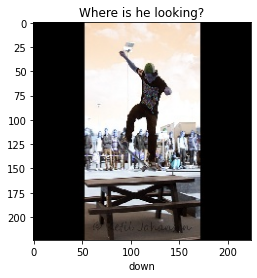

In [18]:
for image_features in parsed_image_dataset:
    image_path = image_features['image_path'].numpy()
    img = cv2.imread(image_path.decode('utf-8'))
    plt.imshow(img)
    plt.title(image_features['question'].numpy().decode('utf-8'))
    plt.xlabel(image_features['answer'].numpy().decode('utf-8'))
    break